# SVM, PCA and SGD Classification on the Diabetes Dataset
This notebook performs data preprocessing, SVM classification (with linear, polynomial, RBF, and sigmoid kernels), PCA visualization, and SGDClassifier optimization using GridSearchCV.

## Imports
We import all libraries required for loading, preprocessing, analyzing, and visualizing the dataset.

In [11]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
import os 
save_path = "../images"
os.makedirs(save_path, exist_ok=True)

## Load the Dataset
We begin by loading the diabetes dataset and inspecting the first few rows.## Load and Explore the Dataset


In [13]:
data = pd.read_csv("../data/diabetes2.csv")
print("Dataset preview:")
print(data.head())

Dataset preview:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


## Handling Missing Values
Some columns contain zero values that are medically impossible (e.g., blood pressure = 0).  
We replace zeros by NaN, then fill missing values with the median of each column.

In [14]:
zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[zero] = data[zero].replace(0, np.nan)

print("\nMissing values before processing:\n", data.isnull().sum())

for col in zero:
    med = data[col].median()
    data[col] = data[col].fillna(med)
    print(f"{col} : missing values replaced with median ({med})")

print("\nMissing values after processing:\n", data.isnull().sum())


Missing values before processing:
 Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Glucose : missing values replaced with median (117.0)
BloodPressure : missing values replaced with median (72.0)
SkinThickness : missing values replaced with median (29.0)
Insulin : missing values replaced with median (125.0)
BMI : missing values replaced with median (32.3)

Missing values after processing:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


## Removing Duplicates
We check for duplicate rows and remove them if needed.

In [15]:
if data.duplicated().sum() > 0:
    data = data.drop_duplicates()
    print("\nDuplicates removed:", data.duplicated().sum())

## Preparing Features and Targets
We separate:
- **X** → features  
- **Y** → target (Outcome)

Then we split data into training and testing sets.

In [16]:
X = data.drop('Outcome', axis=1)
Y = data['Outcome']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

## Standardization
SVMs perform better when features are scaled.  
We use **StandardScaler** to normalize the data.

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Feature Correlation Analysis
We compute the two most correlated features with the target variable (Outcome).

In [18]:
correlations = data.corr()['Outcome'].abs().sort_values(ascending=False)
top_corr = correlations[1:3]
print("Top 2 correlated features:\n", top_corr)

Top 2 correlated features:
 Glucose    0.492782
BMI        0.312038
Name: Outcome, dtype: float64


## SVM with Linear Kernel
We perform hyperparameter tuning using GridSearchCV.

In [19]:
print("\nLinear Kernel")

param_gridL = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['linear'],
}

gridL = GridSearchCV(SVC(), param_gridL, refit=True, cv=5, n_jobs=-1)
gridL.fit(X_train_scaled, Y_train)

print("\nBest parameters:", gridL.best_params_)

best_Lmodel = gridL.best_estimator_
Y_predL_best = best_Lmodel.predict(X_test_scaled)
accL = accuracy_score(Y_test, Y_predL_best)

print("\nAccuracy (Linear Kernel):", accL)
print("\nClassification Report:")
print(classification_report(Y_test, Y_predL_best))


Linear Kernel

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

Accuracy (Linear Kernel): 0.7532467532467533

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154



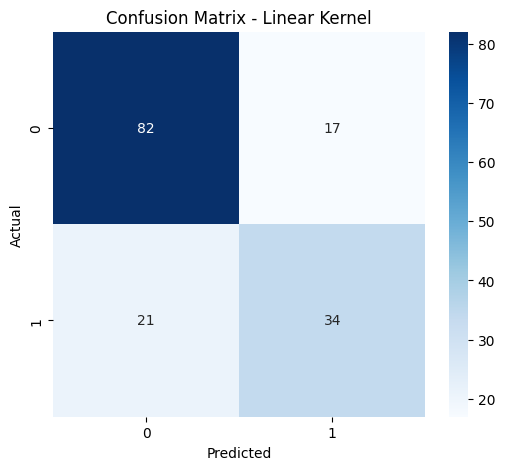

In [20]:
cm = confusion_matrix(Y_test, Y_predL_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Linear Kernel")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(f"{save_path}/Confusion Matrix - Linear Kernel.png", dpi=300)

plt.show()

## SVM with Polynomial Kernel
We tune the polynomial degree and regularization parameters.

In [21]:
print("\nPolynomial Kernel")

param_gridP = {
    'C': [1, 10],
    'kernel': ['poly'],
    'degree': [2, 3],
    'gamma': ['scale']
}

gridP = GridSearchCV(SVC(), param_gridP, cv=5, n_jobs=-1)
gridP.fit(X_train_scaled, Y_train)

print("\nBest parameters:", gridP.best_params_)

best_Pmodel = gridP.best_estimator_
Y_predP_best = best_Pmodel.predict(X_test_scaled)
accP = accuracy_score(Y_test, Y_predP_best)

print("\nAccuracy (Polynomial Kernel):", accP)
print("\nClassification Report:")
print(classification_report(Y_test, Y_predP_best))


Polynomial Kernel

Best parameters: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}

Accuracy (Polynomial Kernel): 0.7402597402597403

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.91      0.82        99
           1       0.73      0.44      0.55        55

    accuracy                           0.74       154
   macro avg       0.74      0.67      0.68       154
weighted avg       0.74      0.74      0.72       154



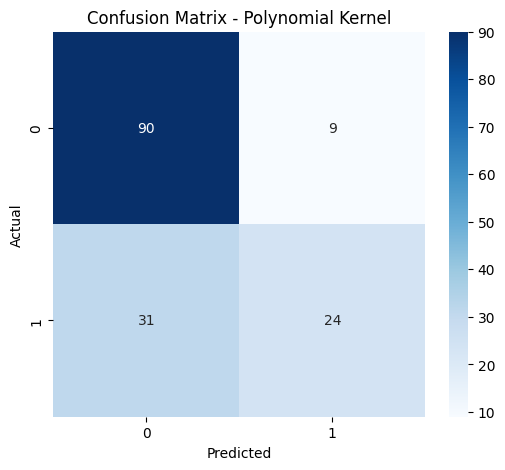

In [22]:
cm = confusion_matrix(Y_test, Y_predP_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Polynomial Kernel")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(f"{save_path}/Confusion Matrix - Polynomial Kernel.png", dpi=300)

plt.show()

## SVM with RBF Kernel
The RBF kernel is powerful for nonlinear classification.

In [23]:
print("\nRBF Kernel")

param_gridR = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['rbf'],
}

gridR = GridSearchCV(SVC(), param_gridR, cv=5)
gridR.fit(X_train_scaled, Y_train)

print("\nBest parameters:", gridR.best_params_)

best_Rmodel = gridR.best_estimator_
Y_predR_best = best_Rmodel.predict(X_test_scaled)
accR = accuracy_score(Y_test, Y_predR_best)

print("\nAccuracy (RBF Kernel):", accR)
print("\nClassification Report:")
print(classification_report(Y_test, Y_predR_best))


RBF Kernel

Best parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

Accuracy (RBF Kernel): 0.7792207792207793

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        99
           1       0.72      0.62      0.67        55

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.78      0.78      0.77       154



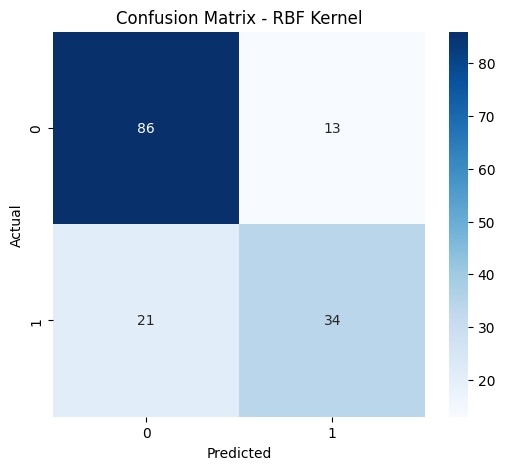

In [24]:
cm = confusion_matrix(Y_test, Y_predR_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - RBF Kernel")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(f"{save_path}/Confusion Matrix - RBF Kernel.png", dpi=300)

plt.show()

## SVM with Sigmoid Kernel
We evaluate an SVM with a sigmoid activation kernel.

In [25]:
print("\nSigmoid Kernel")

param_gridS = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 0.01],
    'kernel': ['sigmoid'],
}

gridS = GridSearchCV(SVC(), param_gridS, cv=5)
gridS.fit(X_train_scaled, Y_train)

print("\nBest parameters:", gridS.best_params_)

best_Smodel = gridS.best_estimator_
Y_predS_best = best_Smodel.predict(X_test_scaled)
accS = accuracy_score(Y_test, Y_predS_best)

print("Accuracy (Sigmoid Kernel):", accS)
print("\nClassification Report:")
print(classification_report(Y_test, Y_predS_best))


Sigmoid Kernel

Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'sigmoid'}
Accuracy (Sigmoid Kernel): 0.7532467532467533

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154



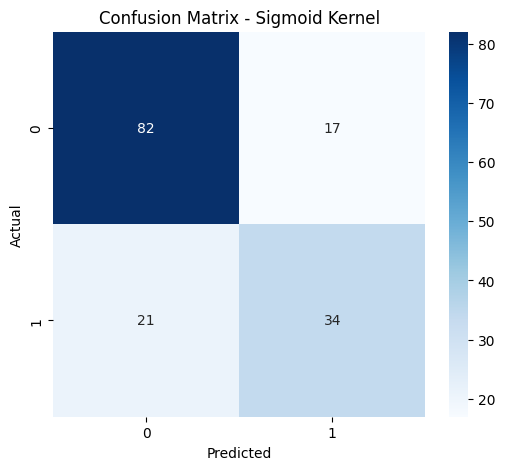

In [26]:
cm = confusion_matrix(Y_test, Y_predS_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Sigmoid Kernel")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(f"{save_path}/Confusion Matrix - Sigmoid Kernel.png", dpi=300)

plt.show()

## Correlation Matrix
We compute and visualize the full correlation matrix.

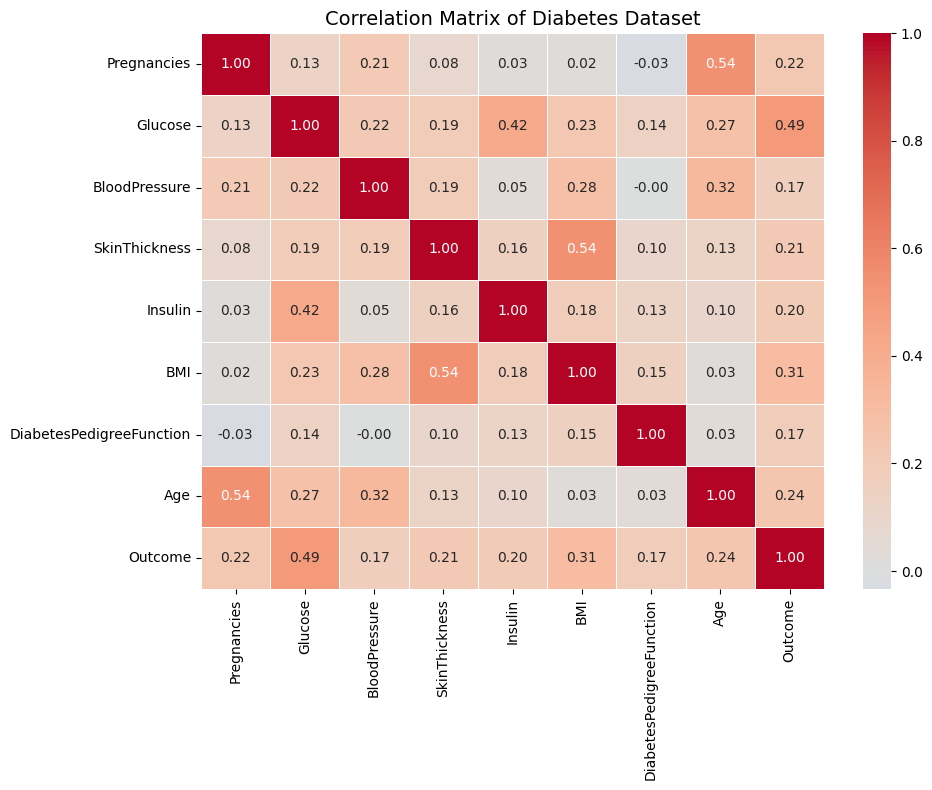

In [27]:
corr_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Diabetes Dataset", fontsize=14)
plt.tight_layout()
plt.savefig(f"{save_path}/Correlation Matrix of Diabetes Dataset.png", dpi=300)

plt.show()

## PCA Visualization with SVM Decision Boundaries
We reduce features to 2D using PCA to visualize SVM decision boundaries.

In [28]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.fit_transform(X))
y = data['Outcome']

print(f"\nExplained variance (2 components): {pca.explained_variance_ratio_.sum():.3f}")


Explained variance (2 components): 0.472


### Plotting Function for Decision Boundaries

In [29]:
def plot_svm_pca_boundary(model, X_pca, y, title, ax):
    h = 0.02
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdBu')
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='RdBu',
                         edgecolors='k', alpha=0.7)
    ax.set_title(title)
    return scatter

### Plot SVM Boundaries for all Kernels (PCA)

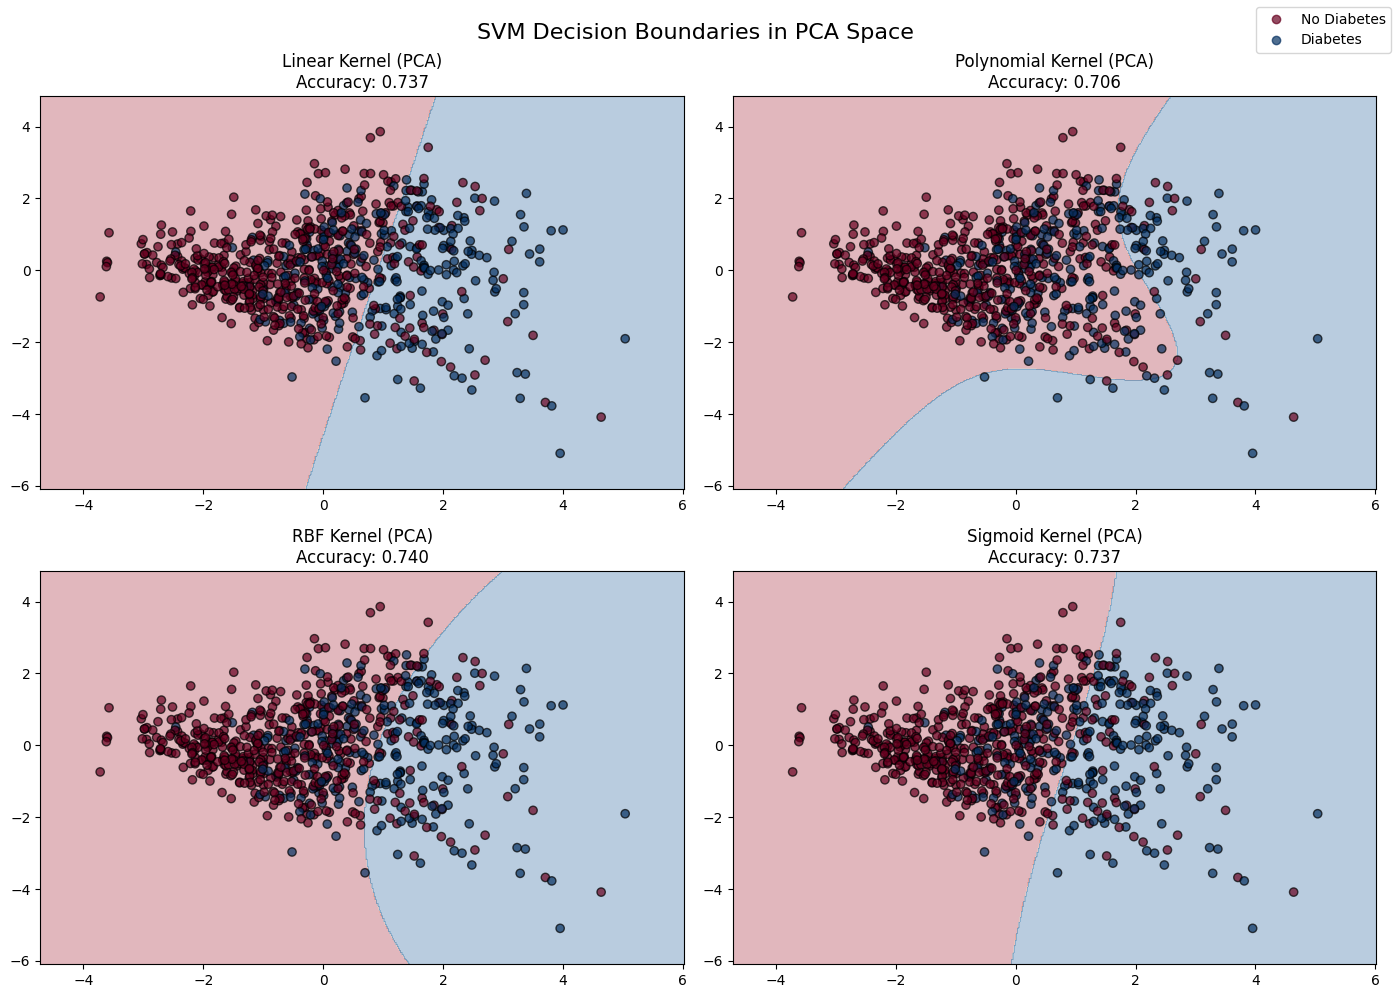

In [30]:
models_pca = {
    'Linear': SVC(kernel='linear', C=gridL.best_params_['C']),
    'Polynomial': SVC(kernel='poly', **{k: v for k, v in gridP.best_params_.items() if k != 'kernel'}),
    'RBF': SVC(kernel='rbf', **{k: v for k, v in gridR.best_params_.items() if k != 'kernel'}),
    'Sigmoid': SVC(kernel='sigmoid', **{k: v for k, v in gridS.best_params_.items() if k != 'kernel'})
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(models_pca.items()):
    model.fit(X_pca, y)
    acc = accuracy_score(y, model.predict(X_pca))
    scatter = plot_svm_pca_boundary(model, X_pca, y,
                                    f"{name} Kernel (PCA)\nAccuracy: {acc:.3f}",
                                    axes[idx])

handles, labels = scatter.legend_elements()
fig.legend(handles, ['No Diabetes', 'Diabetes'], loc='upper right')
plt.suptitle("SVM Decision Boundaries in PCA Space", fontsize=16)
plt.tight_layout()
plt.savefig(f"{save_path}/SVM Decision Boundaries in PCA Space.png", dpi=300)

plt.show()

## SGDClassifier  
We tune the SGD classifier using GridSearchCV.

In [31]:
print("\nSGD Classifier")

param_grid_sgd = {
    'loss': ['hinge', 'log'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['optimal', 'invscaling']
}

grid_sgd = GridSearchCV(SGDClassifier(random_state=42),
                        param_grid_sgd, cv=5, n_jobs=-1)
grid_sgd.fit(X_train_scaled, Y_train)

print("\nBest parameters:", grid_sgd.best_params_)

best_sgd = grid_sgd.best_estimator_
Y_pred_sgd = best_sgd.predict(X_test_scaled)

acc_sgd = accuracy_score(Y_test, Y_pred_sgd)
print("\nAccuracy (SGDClassifier):", acc_sgd)
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_sgd))


SGD Classifier

Best parameters: {'alpha': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'elasticnet'}

Accuracy (SGDClassifier): 0.7727272727272727

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        99
           1       0.70      0.64      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.75       154
weighted avg       0.77      0.77      0.77       154



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
270 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~

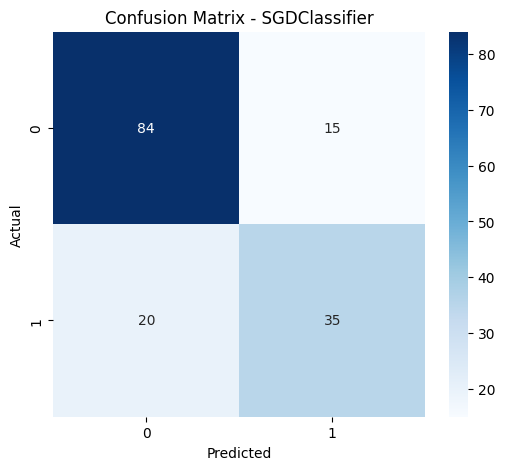

In [32]:
cm_sgd = confusion_matrix(Y_test, Y_pred_sgd)
plt.figure(figsize=(6,5))
sns.heatmap(cm_sgd, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SGDClassifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(f"{save_path}/Confusion Matrix - SGDClassifier.png", dpi=300)

plt.show()

# Conclusion

In this notebook, we applied several classification techniques to the diabetes dataset:

### Key points:
- SVM kernels (linear, poly, RBF, sigmoid)** were optimized using GridSearchCV.
- RBF and Polynomial kernels often perform best** on nonlinear datasets.
- Correlation analysis** helped identify the most influential features.
- PCA enabled a 2D visualization of SVM decision boundaries.
- SGDClassifier** provided a fast alternative using gradient descent.

This project demonstrates the impact of preprocessing, scaling, hyperparameter tuning, and visualization on model performance.
